## Train GPT Model on JSON data


In [1]:
# Imports and Setup
import matplotlib.pyplot as plt
import torch
from IPython.display import clear_output
from transformers import (
    AutoConfig,
    DataCollatorForLanguageModeling,
    GPT2LMHeadModel,
    LlamaConfig,
    LlamaForCausalLM,
    Trainer,
    TrainingArguments,
)

from storm_ml.models import STORM_GPT2HeadModel as STORMHeadModel

# Check if MPS is available
device = torch.device("cpu" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from storm_ml.data import (
    DocPermuterPipe,
    DocTokenizerPipe,
    PadTruncTokensPipe,
    SchemaParserPipe,
    TargetFieldPipe,
    TokenEncoderPipe,
    UpscalerPipe,
    load_df_from_mongodb,
)

# load data into dataframe and split into train/test
# df = load_df_from_mongodb("mongodb://localhost:27017", "codenet", "train", projection={"_id": 0, "filePath": 0})
df = load_df_from_mongodb("mongodb://localhost:27017", "treasurehunt", "dungeon_5_10_3", projection={"_id": 0})
# df = load_df_from_mongodb("mongodb://localhost:27017", "mutagenesis", "mutagenesis", projection={"_id": 0})
# df = load_df_from_mongodb("mongodb://localhost:27017", "openml", "4534-PhishingWebsites", projection={"_id": 0})

train_docs_df, test_docs_df = train_test_split(df, test_size=0.2, shuffle=True)

TARGET_FIELD = "treasure"

# create train and test pipelines
pipes = {
    # --- train only ---
    "schema": SchemaParserPipe(),
    "upscaler": UpscalerPipe(n=4),
    "permuter": DocPermuterPipe(),
    # --- test only ---
    "target": TargetFieldPipe(TARGET_FIELD),
    # --- train and test ---
    "tokenizer": DocTokenizerPipe(path_in_field_tokens=True),
    "padding": PadTruncTokensPipe(length="max"),
    "encoder": TokenEncoderPipe(),
}

train_pipeline = Pipeline([(name, pipes[name]) for name in ("schema", "target", "tokenizer", "padding", "encoder")])
test_pipeline = Pipeline([(name, pipes[name]) for name in ("schema", "target", "tokenizer", "padding", "encoder")])

# process train, eval and test data
train_df = train_pipeline.fit_transform(train_docs_df)
test_df = test_pipeline.transform(test_docs_df)

# allow transitions in vpda to work for test data
# pipes["schema"].fit(test_docs_df)

# get stateful objects
schema = pipes["schema"].schema
encoder = pipes["encoder"].encoder
block_size = pipes["padding"].length

# print data stats
print(f"len train: {len(train_df)}, len test: {len(test_df)}")
print(f"vocab size {encoder.vocab_size}")
print(f"block size {block_size}")

len train: 80000, len test: 20000
vocab size 42
block size 111


In [ ]:
import numpy as np

from storm_ml.vpda import DocumentVPDA

vpda = DocumentVPDA(encoder)

arr = np.array(train_df["tokens"][:20].to_list())
vpda.accepts(arr)


In [3]:
from datasets import Dataset

from storm_ml.utils import Symbol

# Create custom config
config = LlamaConfig(
    vocab_size=encoder.vocab_size,
    bos_token_id=encoder.encode(Symbol.START),
    eos_token_id=encoder.encode(Symbol.END),
    pad_token_id=encoder.encode(Symbol.PAD),
    hidden_size=128,
    num_hidden_layers=4,
    num_attention_heads=4,
    tie_word_embeddings=False,
)


print(config)

# model = STORMHeadModel(config, vpda).to(device)
# model = GPT2LMHeadModel(config).to(device)
model = LlamaForCausalLM(config).to(device)

model.resize_token_embeddings(encoder.vocab_size)

LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 32,
  "hidden_act": "silu",
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "num_key_value_heads": 4,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "transformers_version": "4.45.2",
  "use_cache": true,
  "vocab_size": 42
}



Embedding(42, 128, padding_idx=0)

In [4]:
# prepare HuggingFace Dataset
train_df["input_ids"] = train_df["tokens"]
test_df["input_ids"] = test_df["tokens"]

# train_df.drop(columns=["tokens", "docs", "id"], inplace=True)
# test_df.drop(columns=["tokens", "docs", "id"], inplace=True)

# create HuggingFace datasets from Pandas DataFrames
train_tokenized = Dataset.from_pandas(train_df)
test_tokenized = Dataset.from_pandas(test_df)

# # set format to Torch
train_tokenized.set_format("torch", columns=["input_ids"])
test_tokenized.set_format("torch", columns=["input_ids"])


train_tokenized


Dataset({
    features: ['docs', 'id', 'target', 'tokens', 'input_ids', '__index_level_0__'],
    num_rows: 80000
})

In [5]:
from transformers import AutoTokenizer

dummy_tokenizer = AutoTokenizer.from_pretrained("gpt2")
dummy_tokenizer._pad_token = "<PAD>"
dummy_tokenizer.pad_token_id = encoder.encode(Symbol.PAD)
dummy_tokenizer.padding_side = "right"


In [6]:
from transformers import TrainerCallback


# Custom Callback for plotting
class PlotLossCallback(TrainerCallback):
    def __init__(self, plot_every=100):
        self.plot_every = plot_every
        self.train_losses = []
        self.eval_losses = []
        self.step_count = 0

    def on_step_end(self, args, state, control, **kwargs):
        self.step_count += 1

    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.is_local_process_zero and "loss" in logs:
            self.train_losses.append((self.step_count, logs["loss"]))
            self.plot_losses()
            print(logs)

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        self.eval_losses.append((self.step_count, metrics.get("eval_loss", None)))
        self.plot_losses()
        print(metrics)

    def plot_losses(self):
        clear_output(wait=True)
        plt.figure(figsize=(12, 8))

        # Plot train loss
        train_steps, train_losses = zip(*self.train_losses)
        plt.plot(train_steps, train_losses, label="Train Loss", color="blue", marker="o")

        # Plot eval loss
        if len(self.eval_losses) > 0:
            eval_steps, eval_losses = zip(*self.eval_losses)
            plt.plot(eval_steps, eval_losses, label="Eval Loss", color="red", marker="o")

        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.title("Training Progress")
        plt.legend(loc="upper left")

        plt.show()
        plt.savefig("training_progress.png")


loss_callback = PlotLossCallback()

In [7]:
# Set up training arguments
training_args = TrainingArguments(
    do_train=True,
    do_eval=True,
    output_dir="./checkpoints",
    num_train_epochs=10,
    per_device_train_batch_size=100,
    per_device_eval_batch_size=100,
    warmup_steps=1000,
    warmup_ratio=0.01,
    weight_decay=0.01,
    learning_rate=1e-3,
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=1000,
    save_strategy="no",
    report_to="none",  # Disable wandb logging
)

data_collator = DataCollatorForLanguageModeling(tokenizer=dummy_tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    data_collator=data_collator,
    callbacks=[loss_callback],
)


In [8]:
train_tokenized["input_ids"].shape

torch.Size([80000, 111])

<Figure size 640x480 with 0 Axes>

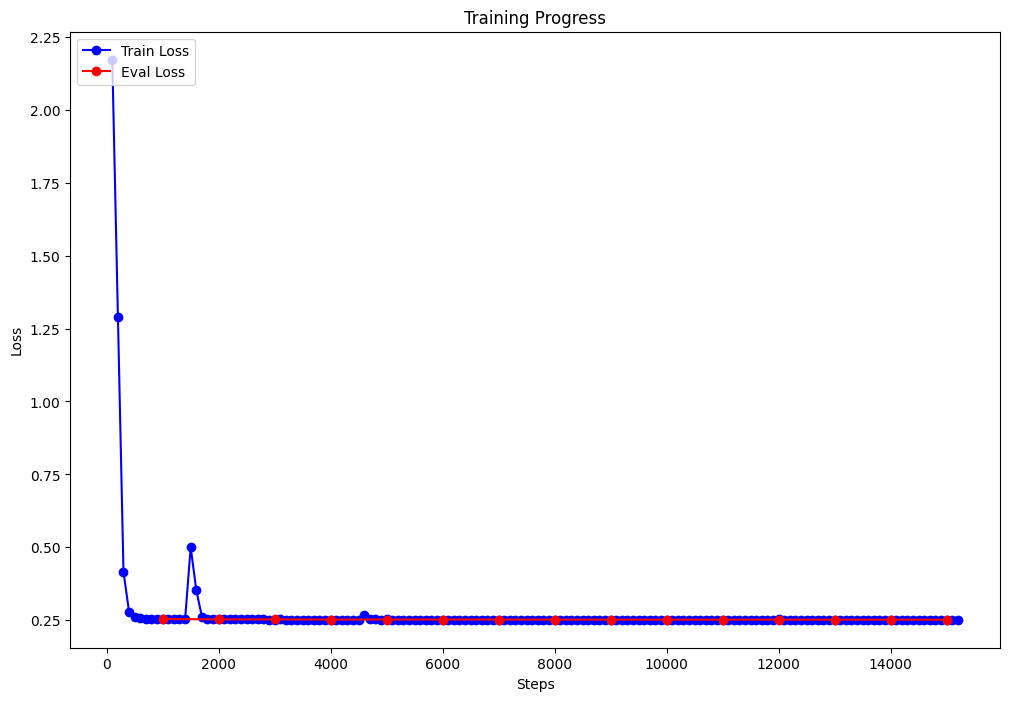

{'loss': 0.2518, 'grad_norm': 0.11310183256864548, 'learning_rate': 5.333333333333334e-05, 'epoch': 19.0}
{'loss': 0.2518, 'grad_norm': 0.11310183256864548, 'learning_rate': 5.333333333333334e-05, 'epoch': 19.0}


In [ ]:
# train model
trainer.train()
loss_callback.plot_losses()

In [10]:
# # Save the model
# model.save_pretrained("./checkpoints/checkpoint-final")
# print("Model saved!")

In [ ]:
from pprint import pprint

import seaborn as sns

from storm_ml.data.utils import detokenize


def get_attention_weights(model, input_ids):
    # Get model outputs
    with torch.no_grad():
        outputs = model(input_ids, output_attentions=True)

    # Extract attention weights
    # Assuming single layer, single head for simplicity
    attention_weights = outputs.attentions[0][0]  # shape: [seq_len, seq_len]
    return attention_weights[0].cpu()


def plot_attention_heatmap(attention_weights, tokens):
    plt.figure(figsize=(10, 8), dpi=300)
    sns.heatmap(attention_weights, xticklabels=tokens, yticklabels=tokens, cmap="YlOrRd")
    plt.title("Attention Heatmap")
    plt.xlabel("Attended Tokens")
    plt.ylabel("Attending Tokens")
    plt.tick_params(axis="both", which="major", labelsize=6)
    plt.tight_layout()
    plt.show()


input_ids = test_tokenized["input_ids"][0]

print(input_ids)
pprint(detokenize(encoder.decode(input_ids)))

# reshape input_ids as 2d tensor
input_ids = input_ids.unsqueeze(0).to(device)
attention_weights = get_attention_weights(model, input_ids)

plot_attention_heatmap(attention_weights, encoder.decode(input_ids[0]))


## Evaluation


In [ ]:
import numpy as np
import torch
from transformers import Trainer, TrainingArguments

# Set up evaluation arguments
eval_args = TrainingArguments(
    output_dir="./checkpoints", do_train=False, do_eval=True, per_device_eval_batch_size=100, dataloader_drop_last=False
)

# Create a Trainer instance for evaluation
eval_trainer = Trainer(model=model, args=eval_args, eval_dataset=test_tokenized, data_collator=data_collator)

# Run evaluation
eval_results = eval_trainer.evaluate()

# Print evaluation results
print("Evaluation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value}")

# Calculate perplexity
perplexity = np.exp(eval_results["eval_loss"])
print(f"Perplexity: {perplexity}")

# Generate some text as a sanity check
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
_ = model.eval()


In [13]:
# single predictions - slow


# import torch
# from tqdm.auto import tqdm

# from storm_ml.utils import FieldToken


# def truncate(tensor, truncate_id):
#     index = (tensor == truncate_id).nonzero()
#     if index.numel() > 0:
#         return tensor[: index[-1] + 1]
#     return tensor


# def predict_label(input_ids: torch.Tensor, model):
#     target_token_id = encoder.encode(FieldToken(TARGET_FIELD))
#     trunc_ids = truncate(input_ids, target_token_id).view(1, -1).to(model.device)

#     # Assuming trunc_ids is your truncated tensor of input IDs
#     attention_mask = torch.ones_like(trunc_ids).to(model.device)

#     with torch.no_grad():
#         # forward pass to get logits, use argmax for next tokens
#         output = model(trunc_ids, attention_mask=attention_mask, labels=trunc_ids)

#     # get predictions
#     predictions = output.logits.argmax(dim=-1)
#     pred = encoder.decode(predictions[0])

#     # output = model.generate(trunc_ids, attention_mask=attention_mask, max_new_tokens=1, do_sample=False)
#     # pred = encoder.decode(output[0, -1])

#     return pred


# predictions = [predict_label(doc, model) for doc in tqdm(test_tokenized["input_ids"])]


In [ ]:
import multiprocessing

import torch
from datasets import Dataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from storm_ml.utils import FieldToken


def truncate(tensor, truncate_id):
    index = (tensor == truncate_id).nonzero()
    if index.numel() > 0:
        return tensor[: index[-1] + 1]
    return tensor


def truncate_dataset(dataset, truncate_func, num_proc=None):
    def truncate_example(example):
        example["input_ids"] = truncate_func(example["input_ids"])
        return example

    # If num_proc is not specified, use the number of CPU cores
    if num_proc is None:
        num_proc = multiprocessing.cpu_count()

    return dataset.map(truncate_example, num_proc=num_proc)


def collate_fn(batch):
    # Extract input_ids from the batch
    input_ids = [item["input_ids"].clone().detach() for item in batch]

    # Find max length in the batch
    max_len = max(len(seq) for seq in input_ids)

    # pad token
    pad_token_id = model.config.pad_token_id

    # Pad sequences and create attention masks
    padded_sequences = []
    attention_masks = []
    for seq in input_ids:
        padding_length = max_len - len(seq)
        # left pad sequences
        padded_seq = torch.cat([torch.full((padding_length,), pad_token_id), seq])
        attention_mask = torch.cat(
            [
                torch.zeros(padding_length),
                torch.ones(len(seq)),
            ]
        )
        padded_sequences.append(padded_seq)
        attention_masks.append(attention_mask)

    # Stack tensors
    padded_sequences = torch.stack(padded_sequences)
    attention_masks = torch.stack(attention_masks)

    return {"input_ids": padded_sequences, "attention_mask": attention_masks}


def batch_next_token_prediction(model, dataset, batch_size=100, device="mps"):
    model.eval()
    all_predictions = []

    # Create a new dataset with truncated sequences
    target_token_id = encoder.encode(FieldToken(TARGET_FIELD))
    truncated_dataset = truncate_dataset(dataset, lambda s: truncate(s, target_token_id))

    # Create a DataLoader with custom collate_fn
    dataloader = DataLoader(truncated_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    for batch in tqdm(
        dataloader,
        desc="Predict",
    ):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # Replace pad token (0) with the model's pad_token_id
        input_ids = torch.where(input_ids == 0, model.config.pad_token_id, input_ids)

        # Get model predictions
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            next_token_logits = outputs.logits[:, -1, :]
            next_token_ids = torch.argmax(next_token_logits, dim=-1)

        all_predictions.extend(next_token_ids.cpu().numpy())

    # decode predictions
    all_predictions = encoder.decode(all_predictions)
    return all_predictions


predictions = batch_next_token_prediction(model, test_tokenized)

In [ ]:
print(predictions[:20])
print(test_tokenized["target"][:20])


In [ ]:
import evaluate

# Load metric
accuracy_metric = evaluate.load("accuracy")

predictions_int = [encoder.encode(pred) for pred in predictions]
references_int = [encoder.encode(ref) for ref in test_tokenized["target"]]

# Compute metrics
results = accuracy_metric.compute(predictions=predictions_int, references=references_int)

print("results: ", results)